<a href="https://colab.research.google.com/github/Ibraheem101/Data-Science-learning/blob/main/rnn-name-classification/rnn_name_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/Ibraheem101/Data-Science-learning.git

Cloning into 'Data-Science-learning'...
remote: Enumerating objects: 129, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 129 (delta 27), reused 0 (delta 0), pack-reused 78
Receiving objects: 100% (129/129), 4.48 MiB | 13.15 MiB/s, done.
Resolving deltas: 100% (43/43), done.


In [2]:
import io
import os
import re
import glob
import json
import math
import nltk
import torch
import gensim
import string
import random
import urllib
import requests
import itertools
import collections
import numpy as np
import unicodedata
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
os.getcwd()

'/content'

In [4]:
new_directory = '/content/Data-Science-learning/rnn-name-classification/'
os.chdir(new_directory)

In [5]:
os.getcwd()

'/content/Data-Science-learning/rnn-name-classification'

In [6]:
from IPython.display import Image, display

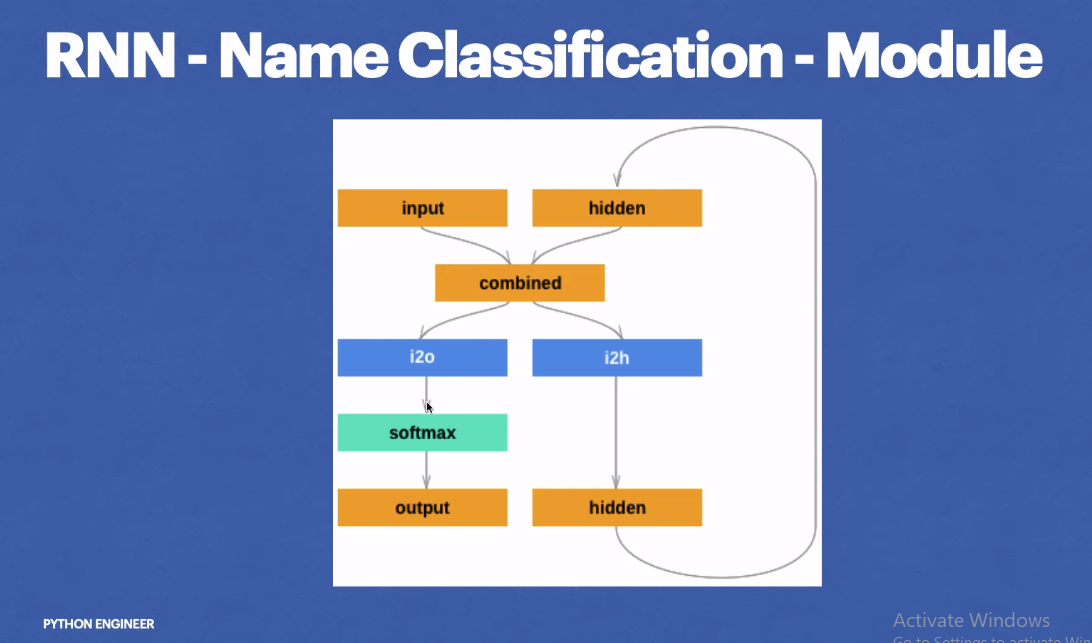

In [7]:
image_path = 'images/rnn.png'
display(Image(filename=image_path))

In [8]:
from utils import all_letters, n_letters
from utils import load_data, letter_to_tensor, line_to_tensor, random_training_example

In [9]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.softmax = nn.LogSoftmax(dim = 1)

    def forward(self, X, hidden):
        combined = torch.cat((X, hidden), 1)
        output = self.i2o(combined)
        output = self.softmax(output)
        hidden = self.i2h(combined)

        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [10]:
category_lines, all_categories = load_data()

In [11]:
all_categories

['Scottish',
 'Portuguese',
 'Russian',
 'English',
 'Vietnamese',
 'Greek',
 'German',
 'Czech',
 'Polish',
 'Japanese',
 'Arabic',
 'French',
 'Korean',
 'Italian',
 'Dutch',
 'Irish',
 'Chinese',
 'Spanish']

In [12]:
n_categories = len(all_categories)
n_hidden = 64

In [13]:
rnn = RNN(n_letters, n_hidden, n_categories)

In [14]:
# Test
x = line_to_tensor('Shadid')
hidden = rnn.init_hidden()

output, next_hidden = rnn(x[0], hidden)
print(output.size(), next_hidden.size())

torch.Size([1, 18]) torch.Size([1, 64])


In [15]:
torch.argmax(torch.tensor([[23, 45, 56],[89, 7, 90]]))

tensor(5)

In [16]:
def category_from_output(output):
    category_idx = torch.argmax(output).item() #.item() outputs the value instead of the tensor
    return all_categories[category_idx]

In [17]:
category_from_output(output)

'Portuguese'

#### Training

In [18]:
# Create the NLLLoss instance
criterion = nn.NLLLoss()
lr = 0.0001
optimizer = torch.optim.SGD(rnn.parameters(), lr = lr)

In [19]:
def train(line_tensor, category_tensor):
    hidden = rnn.init_hidden() # Initial hidden value

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return output, loss.item()

In [20]:
sum_losses = 0
losses = []
plot_steps, print_steps = 1000, 5000
epochs = 100000

In [21]:
for epoch in range(epochs):
    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)
    output, current_loss = train(line_tensor, category_tensor)
    sum_losses += current_loss


    if (epoch+1) % plot_steps == 0:
        losses.append((current_loss/epoch) * 100)

    if (epoch+1) % print_steps == 0:
        guess = category_from_output(output)
        correct = "CORRECT" if guess == category else f"WRONG ({category})"
        print(f"{epoch+1} {(epoch+1)/epochs*100} {current_loss:.4f} {line} / {guess} {correct}")


5000 5.0 2.8738 Kouches / Vietnamese WRONG (Greek)
10000 10.0 2.8114 Peij / English WRONG (Dutch)
15000 15.0 2.8385 Dufour / Vietnamese WRONG (French)
20000 20.0 2.9604 Madden / Chinese WRONG (Irish)
25000 25.0 3.0209 Charron / Vietnamese WRONG (French)
30000 30.0 2.8970 Abel / English WRONG (Spanish)
35000 35.0 2.8550 Huynh / German WRONG (Vietnamese)
40000 40.0 2.9974 Baudin / Dutch WRONG (French)
45000 45.0 2.8242 Koury / German WRONG (Arabic)
50000 50.0 2.7970 Vasquez / Arabic WRONG (Spanish)
55000 55.00000000000001 2.9504 Thom / Arabic WRONG (English)
60000 60.0 2.8467 Faolan / Scottish WRONG (Irish)
65000 65.0 2.7525 Franco / Spanish CORRECT
70000 70.0 2.8625 D'cruz / Vietnamese WRONG (Portuguese)
75000 75.0 2.9600 Gravari / Italian WRONG (Greek)
80000 80.0 2.9606 Desrochers / Greek WRONG (French)
85000 85.0 2.7104 Geng / Chinese CORRECT
90000 90.0 2.8460 Tannous / Greek WRONG (Arabic)
95000 95.0 2.7480 Abarca / Spanish CORRECT
100000 100.0 2.7533 Narvaez / Arabic WRONG (Spanish)

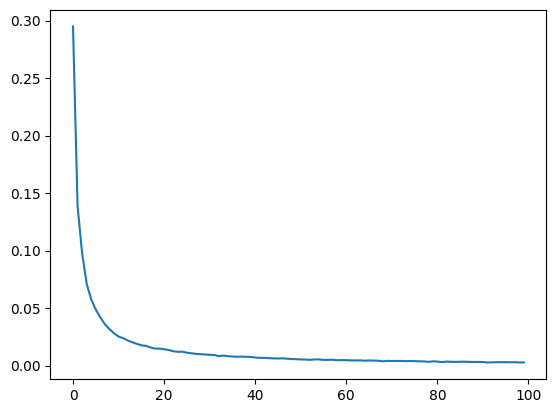

In [22]:
plt.figure()
plt.plot(losses)
plt.show()

#### Predict

In [23]:
def predict(input_line):
    print(f"\n> {input_line}")
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)

        hidden = rnn.init_hidden()

        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)

        guess = category_from_output(output)
        print(guess)

In [26]:
while True:
    name = input("Enter a name or type 'quit' to quit: ")

    if name == 'quit':
        break
    predict(name)

Enter a name or type 'quit' to quit: ibrahim

> ibrahim
Arabic
Enter a name or type 'quit' to quit: Salim

> Salim
Arabic
Enter a name or type 'quit' to quit: Jo

> Jo
Portuguese
Enter a name or type 'quit' to quit: Washington

> Washington
Scottish
Enter a name or type 'quit' to quit: Daniel

> Daniel
English
Enter a name or type 'quit' to quit: James

> James
Greek
Enter a name or type 'quit' to quit: Luqman

> Luqman
Scottish
Enter a name or type 'quit' to quit: Mack

> Mack
English
Enter a name or type 'quit' to quit: quit
